<CostaRican Household proverty>
미주개발은행의 세계에서 가장 빈곤한 일부 가정의 소득자격 예측 
다양한 피쳐들로 LGBM Classifier를 활용. 

   
    **LGBM : Light GBM  
XGBoost에 비해 훈련 시간이 짧고 성능도 좋아 부스팅 알고리즘에서 가장 많은 주목을 받고 있다.

GradientBoosting을 발전시킨 것이 XGBoost, 여기서 속도를 더 높인 것이 LightGBM이다.
    
장점

1. 학습하는데 시간이 짧다. (통상 XGBoost 학습속도의 1.3~1.5배)

2. 메모리 사용량이 상대적으로 적다.

3. 대용량 데이터 처리 가능

 

단점

1. 적은 데이터셋(공식문서 기준 만건 이하)에서는 오버피팅 발생 가능
    
공식 문서: https://lightgbm.readthedocs.io/en/latest/index.html 
    

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

In [13]:
!pip install featuretools

  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730985 sha256=16624390448092c2fa6c02e62a399cdecf361fac0239108b5e5e74595fca6bb3
  Stored in directory: c:\users\82102\appdata\local\pip\cache\wheels\33\3d\82\4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2


In [14]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools 
import lightgbm as lgb 
import xgboost as xgb 
from xgboost import XGBClassifier 
from tqdm import tqdm 
import shap 
import featuretools as ft 
import warnings 
warnings.filterwarnings('ignore')
import time 

In [190]:
#1. Check Datasets
#1.1 Read dataset 

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [191]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape:', df_test.shape)

df_train shape: (9557, 143)    df_test shape: (23856, 142)


In [192]:
df_train.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  ...  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
0     0  ...          100    1849               1        100             0   
1     0  ...          144    4489               1        144             0   
2     0  ...          121    8464               1          0             0   
3     0  ...           81     289              16        121             4   
4     0  ...          121    1369              16        121             4   

   SQBovercrowding  SQBdependency  SQBmeaned  agesq  Target  
0         1.000000            0.0      100.0   1849       4  
1         1.000000           64.0      144.0   4489       4  
2         0.250000           64.0      121.0   8464       4  
3         1.777778            1.0      121.0    289       4  
4         1.777778            1.0      121.0   1369       4  

[5 rows x 143 columns]

In [193]:
df_test.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_2f6873615       NaN       0      5       0     1       1     0    NaN   
1  ID_1c78846d2       NaN       0      5       0     1       1     0    NaN   
2  ID_e5442cf6a       NaN       0      5       0     1       1     0    NaN   
3  ID_a8db26a79       NaN       0     14       0     1       1     1    1.0   
4  ID_a62966799  175000.0       0      4       0     1       1     1    1.0   

   r4h1  ...  age  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  \
0     1  ...    4            0      16               9          0   
1     1  ...   41          256    1681               9          0   
2     1  ...   41          289    1681               9          0   
3     0  ...   59          256    3481               1        256   
4     0  ...   18          121     324               1          0   

   SQBhogar_nin  SQBovercrowding  SQBdependency  SQBmeaned  agesq  
0             1             2.25           0.25     272.25     16  
1             1             2.25           0.25     272.25   1681  
2             1             2.25           0.25     272.25   1681  
3             0             1.00           0.00     256.00   3481  
4             1             0.25          64.00        NaN    324  

[5 rows x 142 columns]

In [194]:
#1.2 Make description df 

description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [195]:
description

varname                         description
0               v2a1                Monthly rent payment
1             hacdor         =1 Overcrowding by bedrooms
2              rooms    number of all rooms in the house
3             hacapo            =1 Overcrowding by rooms
4               v14a      =1 has toilet in the household
..               ...                                 ...
136     SQBhogar_nin                   hogar_nin squared
137  SQBovercrowding                overcrowding squared
138    SQBdependency                  dependency squared
139        SQBmeaned                      meaned squared
140            agesq                         Age squared

[141 rows x 2 columns]

In [196]:
description_ko=[("v2a1","월세납부"),
("hacdor","=1 침실별 과잉 수용"),
("rooms","집 안의 모든 방의 수"),
("hacapo","=1실별 과잉 수용"),
("v14a","=1 가정에 화장실 있음"),
("refrig","=1가구에 냉장고가 있는 경우"),
("v18q","태블릿 소유"),
("v18q1","가구 소유의 태블릿 수"),
("r4h1","12세 미만의 남성"),
("r4h2","남성 12세 이상"),
("r4h3","가구원수합계"),
("r4m1","12세 이하 여성"),
("r4m2","12세 이상 여성"),
("r4m3","가구원 총여성"),
("r4t1","12세 이하인 사람"),
("r4t2","12세 이상"),
("r4t3","가구원 합계"),
("tamhog","가구원수"),
("tamviv","가구원수"),
("escolari","다년간의 교육"),
("rez_esc","학창시절 몇년 뒤"),
("hhsize","가구 크기"),
("paredblolad","=1 외벽의 주요 재료가 블록 또는 벽돌인 경우"),
("paredzocalo","=1 외벽의 주요 재료가 소켓인 경우(목재, 아연 또는 압베스토"),
("paredpreb","=1 외벽의 주요 재료가 사전 조립 또는 시멘트인 경우"),
("pareddes","=1 외벽의 주요 소재가 폐자재일 경우"),
("paredmad","=1 외벽의 주요 재료가 목재인 경우"),
("paredzinc","=1 외벽의 주요 재료가 징크인 경우"),
("paredfibras","=1 외벽의 주요 소재가 천연섬유일 경우"),
("paredother","=1 외벽의 주요 재료가 다른 경우"),
("pisomoscer","=1 바닥의 주요 재료가 모자이크 세라믹 테라조인 경우"),
("pisocemento","=1 바닥의 주요 재료가 시멘트인 경우"),
("pisoother","=1 바닥의 주요 재료가 다른 경우"),
("pisonatur","=1 바닥의 주요 재료가 천연 재료인 경우"),
("pisonotiene","=가정에 층이 없는 경우 1개"),
("pisomadera","=1 바닥의 주요 재료가 목재인 경우"),
("techozinc","=1 지붕의 주요 재료가 금속 포일 또는 징크인 경우"),
("techoentrepiso","=1 지붕의 주요 재료가 섬유 시멘트, 메자닌인 경우 "),
("techocane","=1 지붕의 주요 재료가 천연 섬유인 경우"),
("techootro","=1 지붕의 주요 재료가 다른 경우"),
("cielorazo","=1 집에 천장이 있는 경우"),
("abastaguadentro","=1 주거지 내부의 급수인 경우"),
("abastaguafuera","=1 주거지 외부에 물이 공급되는 경우"),
("abastaguano","=1 물 공급이 없는 경우"),
("public","=CNFL, ICE, ESPH/JASEC에서 나오는 전기 1개"),
("planpri","=민간 발전소에서 나오는 전기 1개"),
("noelec","=1주거지에 전기가 없음"),
("coopele","=협동조합 전기 1개"),
("sanitario1","=1주거지에 화장실 없음"),
("sanitario2","=하수도 또는 하수구에 연결된 화장실 1개"),
("sanitario3","= 정화조에 연결된 화장실 1개"),
("sanitario5","=블랙홀 또는 레트린에 연결된 화장실 1개"),
("sanitario6","=다른 시스템에 연결된 화장실 1개"),
("energcocinar1","=1 요리에 사용되는 주요 에너지원이 없음(주방 없음"),
("energcocinar2","=1 전기 조리에 사용되는 주요 에너지 공급원"),
("energcocinar3","=요리가스에 사용되는 주요 에너지 공급원 1개"),
("energcocinar4","=1 목재 숯 조리에 사용되는 주요 에너지원"),
("elimbasu1","=1 유조선 트럭에 의한 쓰레기 처리의 경우"),
("elimbasu2","=1 주로 식물성 중공 또는 매립에 의한 쓰레기 처리"),
("elimbasu3","=1 주로 불에 태워 폐기물을 처리하는 경우"),
("elimbasu4","=1 빈 공간에 주로 던져서 쓰레기를 처리하는 경우"),
("elimbasu5","=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우"),
("elimbasu6","=1 쓰레기 처리가 주로 다른 경우"),
("epared1","=벽이 나쁜 경우 1"),
("epared2","=1 벽이 정규적인 경우"),
("epared3","=벽이 좋은 경우 1개"),
("etecho1","=1 지붕이 나쁜 경우"),
("etecho2","=1 지붕이 정규적인 경우"),
("etecho3","=1 지붕이 양호한 경우"),
("eviv1","=1 바닥이 나쁜 경우"),
("eviv2","=1 바닥이 규칙적인 경우"),
("eviv3","=1 바닥이 좋은 경우"),
("dis","=1 장애인일 경우"),
("male","=1 남성일 경우"),
("female","=1 여성인 경우"),
("estadocivil1","=10세 미만인 경우 1개"),
("estadocivil2","=자유 또는 커플링된 경우 1개"),
("estadocivil3","=결혼한 경우 1개"),
("estadocivil4","=이혼한 경우 1개"),
("estadocivil5","=1 별거한 경우"),
("estadocivil6","=과부 경우 1개"),
("estadocivil7","=싱글일 경우 1개"),
("parentesco1","=가정의 가장일의 경우 1개"),
("parentesco2","=배우자/파트너일 경우 1개"),
("parentesco3","=아들/딸일 경우 1개"),
("parentesco4","=의붓아들/딸 일 경우"),
("parentesco5","=법률상 아들/딸일 경우 1개"),
("parentesco6","=손자/손자일 경우"),
("parentesco7","=어머니/아버지인 경우"),
("parentesco8","=법률상 아버지/어머니일 경우 1개"),
("parentesco9","=형/동생인 경우 1개"),
("parentesco10","=법률상 형제/자매인 경우 1개"),
("parentesco11","=1 다른 가족 구성원의 경우"),
("parentesco12","=1 가족이 아닌 다른 구성원의 경우"),
("idhogar","가구 수준 식별자"),
("hogar_nin","0~19세인 가구원 수 "),
("hogar_adul","어른인 가구원수"),
("hogar_mayor","65세 이상인 가구원수 "),
("hogar_total","가구원 총 인원수"),
("dependency","종속율"),
("edjefe","남성 가장의 수년간 교육"),
("edjefa","여성 가장의 수년간 교육"),
("meaneduc","평균 성인 교육년(18+)"),
("instlevel1","=1 교육 수준 없음"),
("instlevel2","=1 불완전한 초등교육"),
("instlevel3","=1 완전한 초등교육"),
("instlevel4","=1 불완전한 학업 2차 수준"),
("instlevel5","=1 완전한 학문적 2차 수준"),
("instlevel6","=1 불완전한 기술 2차 수준"),
("instlevel7","=1 완전한 기술 2차 수준"),
("instlevel8","=1학부 이상"),
("instlevel9","=1 대학원 고등교육"),
("bedrooms","침실 수"),
("overcrowding","# 객실당 인원수"),
("tipovivi1","=1자체 및 완전유급주택"),
("tipovivi2","=1개 소유, 할부 결제"),
("tipovivi3","=1 임대"),
("tipovivi4","=1 불안정한"),
("tipovivi5","=1 다른사람에게 할당된"),
("computer","=1 가구에 노트북 또는 데스크탑 컴퓨터가 있는 경우, 대여"),
("television","=1가구에 TV가 있는 경우"),
("mobilephone","=휴대전화일 경우 1"),
("qmobilephone","휴대전화 번호"),
("lugar1","=1 지역 중심"),
("lugar2","=1 지역 Chorotega"),
("lugar3","=1 지역 PacÃƒÂ­fico central"),
("lugar4","=1 지역 Brunca"),
("lugar5","=1 지역 Huetar AtlÃƒÂ¡ntica"),
("lugar6","=1 지역 Huetar Norte"),
("area1","=1 조나 우르바나"),
("area2","=2 조나 시골"),
("age","연령"),
("SQBescolari","에스코라리 제곱"),
("SQBage","나이 제곱"),
("SQBhogar_total","hogar_total 제곱"),
("SQBedjefe","에드제프 제곱"),
("SQBhogar_nin","hogar_nin 제곱"),
("SQBovercrowding","과밀 제곱"),
("SQBdependency","종속성 제곱"),
("SQBmeaned","평균 제곱"),
("agesq","나이 제곱"),]

description_ko = pd.DataFrame(description_ko, columns=['varname', 'description'])

In [197]:
description_ko

varname    description
0               v2a1           월세납부
1             hacdor   =1 침실별 과잉 수용
2              rooms   집 안의 모든 방의 수
3             hacapo     =1실별 과잉 수용
4               v14a  =1 가정에 화장실 있음
..               ...            ...
136     SQBhogar_nin   hogar_nin 제곱
137  SQBovercrowding          과밀 제곱
138    SQBdependency         종속성 제곱
139        SQBmeaned          평균 제곱
140            agesq          나이 제곱

[141 rows x 2 columns]

In [198]:
#1.3 Check null data

total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False) 

missing_df = pd.concat([total,percent], axis = 1, keys= ['Total','Percent'])

missing_df.head(20)

Total    Percent
rez_esc        7928  82.954902
v18q1          7342  76.823271
v2a1           6860  71.779847
SQBmeaned         5   0.052318
meaneduc          5   0.052318
Id                0   0.000000
hogar_adul        0   0.000000
parentesco10      0   0.000000
parentesco11      0   0.000000
parentesco12      0   0.000000
idhogar           0   0.000000
hogar_nin         0   0.000000
dependency        0   0.000000
hogar_mayor       0   0.000000
hogar_total       0   0.000000
edjefe            0   0.000000
edjefa            0   0.000000
instlevel1        0   0.000000
instlevel2        0   0.000000
parentesco9       0   0.000000

In [199]:
#1.4 Filling Missing values 

# education이 "yes"이고, 가장이라면, escolari의 년수로 칸을 채운다.
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] ==1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] ==1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] ==1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] ==1), "escolari"]

In [200]:
# 가정의 가장이라면(edjefa, edjefe) 교육 년수는 4년으로 채운다.
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

In [201]:
# 가정의 가장(head of household)가 여성(edjefa)/남성(edjefe)로 구분되어 있는데, 둘중에 큰 값을 하나의 컬럼으로 합친다.
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

In [202]:
# 데이터 불일치를 수정한다.
# 예를 들어 일부행은 화장실을 갖고 있다고 하거나, 가지고 있지 않다고 한다. 
# 우리는 만약 물이 없다면 그들은 물을 마시지 않는다고 가정한다.
df_train.loc[(df_train.v14a == 1) & (df_train.sanitario1 == 1) & (df_train.abastaguano == 0), 'v14a' ] = 0
df_train.loc[(df_train.v14a == 1) & (df_train.sanitario1 == 1) & (df_train.abastaguano == 0), 'sanitario1' ] = 0

df_test.loc[(df_test.v14a == 1) & (df_test.sanitario1 == 1) & (df_test.abastaguano == 0), 'v14a' ] = 0
df_test.loc[(df_test.v14a == 1) & (df_test.sanitario1 == 1) & (df_test.abastaguano == 0), 'sanitario1' ] = 0

In [203]:
# rez_esc : 학창시절 몇년 뒤는 0으로 채운다.
# SQBmeaned : 가장의 평균 교육 년수가 없으면 0으로 채운다.
# meaneduc : 평균 교육 년수가 없다면 0으로 채운다.
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

In [204]:
#v18q1: 가구에서 소유한 태블릿 수 
#if v18q(Do you own a tablet?) == 1, there are some values
# If not, only NaN values in v18q1. See below 3 cells.
# 아예 없으면 0 하나라도 있으면 1 

df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [205]:
#가정에 태블릿이 하나라도 있는 경우 태블릿 수 체크 
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [206]:
#가정에 태블릿이 하나라도 없는 경우 가구당 태블릿 수 체크 
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [207]:
#비어있는 값 채우기 
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

In [208]:
#v2a1: 가구당 소유한 태블릿 수, 
# 그러나 if tipovivi3(rented?) == 1 렌탈한 경우 고려해줘야함 

df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

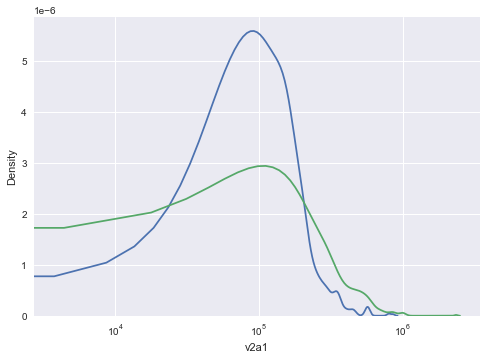

In [209]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==1,'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==0,'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [210]:
#null data 채우기 
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [211]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

Total  Percent
edjef          9557    100.0
v2a1              0      0.0
parentesco10      0      0.0
parentesco11      0      0.0
parentesco12      0      0.0
idhogar           0      0.0
hogar_nin         0      0.0
hogar_adul        0      0.0
hogar_mayor       0      0.0
hogar_total       0      0.0
dependency        0      0.0
edjefe            0      0.0
edjefa            0      0.0
meaneduc          0      0.0
instlevel1        0      0.0
instlevel2        0      0.0
instlevel3        0      0.0
parentesco9       0      0.0
parentesco8       0      0.0
parentesco7       0      0.0

In [212]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

Total  Percent
edjef         23856    100.0
hogar_mayor       0      0.0
parentesco10      0      0.0
parentesco11      0      0.0
parentesco12      0      0.0
idhogar           0      0.0
hogar_nin         0      0.0
hogar_adul        0      0.0
hogar_total       0      0.0
parentesco8       0      0.0
dependency        0      0.0
edjefe            0      0.0
edjefa            0      0.0
meaneduc          0      0.0
instlevel1        0      0.0
instlevel2        0      0.0
parentesco9       0      0.0
parentesco7       0      0.0
instlevel4        0      0.0
estadocivil5      0      0.0

In [213]:
#2. Feature Engineering 
#2.1 object features

features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

In [214]:
#제곱으로 들어간 dependency 원래로 돌리기 
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

In [215]:
#edjefe: 교육연수가 있다는 가정하에 남자 가장의 교육연수 여부

def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

In [216]:
#edjefa: 교육연수가 있다는 가정하에 여자 가장의 교육연수 여부

def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [217]:
# 여자나 남자 중에 가장의 교육연수가 가장 큰 값으로 변수를 생성한다.
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

In [218]:
#roof and electricity 
#초기화 

df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0) :
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0) :
        return 1
    else:
        return 0
    
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis=1)

In [219]:
#2.2 카테고리 변수 추출
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]
len(binary_cat_features) # 이진 카테고리 변수 추출 

103

In [220]:
#2.3 연속형 변수를 사용하여 새로운 변수 생성 
#연속형 변수 컬럼 추출 

continuous_features = [col for col in df_train.columns if col not in binary_cat_features] # unique한 value가 2개일 경우(이진 값)
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target','idhogar']]

In [221]:
print('Threr are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description_ko.loc[description_ko['varname'] == col, 'description'].values))

Threr are 37 continuous features
v2a1: ['월세납부']
rooms: ['집 안의 모든 방의 수']
v18q1: ['가구 소유의 태블릿 수']
r4h1: ['12세 미만의 남성']
r4h2: ['남성 12세 이상']
r4h3: ['가구원수합계']
r4m1: ['12세 이하 여성']
r4m2: ['12세 이상 여성']
r4m3: ['가구원 총여성']
r4t1: ['12세 이하인 사람']
r4t2: ['12세 이상']
r4t3: ['가구원 합계']
tamhog: ['가구원수']
tamviv: ['가구원수']
escolari: ['다년간의 교육']
rez_esc: ['학창시절 몇년 뒤']
hhsize: ['가구 크기']
elimbasu5: ['=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우']
hogar_nin: ['0~19세인 가구원 수 ']
hogar_adul: ['어른인 가구원수']
hogar_mayor: ['65세 이상인 가구원수 ']
hogar_total: ['가구원 총 인원수']
meaneduc: ['평균 성인 교육년(18+)']
bedrooms: ['침실 수']
overcrowding: ['# 객실당 인원수']
qmobilephone: ['휴대전화 번호']
age: ['연령']
SQBescolari: ['에스코라리 제곱']
SQBage: ['나이 제곱']
SQBhogar_total: ['hogar_total 제곱']
SQBedjefe: ['에드제프 제곱']
SQBhogar_nin: ['hogar_nin 제곱']
SQBovercrowding: ['과밀 제곱']
SQBdependency: ['종속성 제곱']
SQBmeaned: ['평균 제곱']
agesq: ['나이 제곱']
edjef: []


In [222]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [223]:
#여기서 tamhog와 hhsize는 사실상 동일한 의미이므로 tamhog는 삭제 
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

#Squared Features 처리 
#현 dataset에는 많은 squared features가 있는데 LGBM같은 트리모델에서는 squared feature는 필요없다 
#하지만 classfier로써 임배딩되어 있는 features 필터와 set entity로써는 lightgbm으로 사용할 수 있으므로 일단 둔다 

#Family features
hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari
Family size features(추출 및 비율구하기)

In [224]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_train['adult']= df_train['hogar_adul'] - df_train['hogar_mayor']# 65이하 성인 명수
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']# 65이상 노인과 0~19살 어린이,청소년
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']# 의존률 노약자/성인
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']# 어린이 비율
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']# 노인 비율
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total'] # 성인 비율 
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total'] # 12세 이하 남자 비율 
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total'] # 12세 이상 남자 비율 
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total'] # 총 가구원수의 남자 비율 
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total'] # 12세 이하 여자 비율 
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total'] # 12세 이상 여자 비율 
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total'] # 총 가구원수의 여자 비율 
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total'] # 12세 이하 가구원수 비율 
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total'] # 12세 이상 가구원수 비율 
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total'] # 총 성인의 가구원수 비율 

In [225]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_test['adult']= df_test['hogar_adul'] - df_test['hogar_mayor'] # 65이하 성인 명수
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor'] # 65이상 노인과 0~19살 어린이,청소년
df_test['dependency'] = df_test['dependency_count'] / df_test['adult'] # 의존률 노약자/성인
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total'] # 어린이 비율
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total'] # 노인 비율
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total'] # 성인 비율 
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total'] # 12세 이하 남자 비율 
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total'] # 12세 이상 남자 비율 
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']# 총 가구원수의 남자 비율 
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']# 12세 이하 여자 비율 
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']# 12세 이상 여자 비율 
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']# 총 가구원수의 여자 비율 
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total'] # 12세 이하 가구원수 비율 
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']# 12세 이상 가구원수 비율
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total'] # 총 성인의 가구원수 비율 

In [226]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [227]:
# 남자, 여자 , 총인원의 가구원수의 비율 
df_test['males_younger_12_years_in_householde_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_householde_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_householde_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_householde_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_householde_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_householde_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_householde_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_householde_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_householde_size'] = df_test['r4t3'] / df_test['hhsize']


In [228]:
# 침실 평균 최대 수용인원 
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [229]:
# 나이대별 교육 연수
df_train['escolari_age'] = df_train['escolari'] / df_train['age']
df_test['escolari_age'] = df_test['escolari'] / df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']

In [230]:
# 실제 가구원수의 생활 방식 비율 
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

"Total persons in the household"와 "# of total individuals in the household"가 같지 않음을 확인할 수 있다.
조금 이상하긴 하지만 지금은 그냥 둔다

In [231]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

In [232]:
#가족 변수의 대출 비율 따져보기 

family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

In [233]:
#ratio는 값이 무한으로 갈 수 있으므로 그런 값들은 0으로 처리해줘야 함 
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [234]:
#가족변수 방 비율 따져보기 (room/family)
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [235]:
#가족변수 침실 비율 (bedroom/family)
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [236]:
#feature 수 확인 
print(df_train.shape, df_test.shape)

(9557, 220) (23856, 219)


In [237]:
#태블릿 보유 비율 
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [238]:
#핸드폰 보유 비율 
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [239]:
#학창시절의 몇년 뒤 비율 
#rez_esc(Years behind in school:학창 시절의 몇년 뒤) per family features

new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [240]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

In [241]:
#rich features : 폰이나 태블릿이 많으면 rich하다고 판단하는 관련 변수 생성 
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

wall(벽), roof(지붕), floor(바닥)도 중요한 키요소이다.
이제 변수들의 값을 곱해보자. 왜냐하면 그 변수들은 이진 카테고리 변수이기 때문이다. 그래서 각각의 변수들의 곱으로 새로운 카테고리 변수를 생성한다.
"epared1"," =1 if walls are bad"
"epared2"," =1 if walls are regular"
"epared3"," =1 if walls are good"
"etecho1"," =1 if roof are bad"
"etecho2"," =1 if roof are regular"
"etecho3"," =1 if roof are good"
"eviv1"," =1 if floor are bad"
"eviv2"," =1 if floor are regular"
"eviv3"," =1 if floor are good"

In [242]:
# wall and roof
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['etecho1','etecho2','etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['eviv1','eviv2','eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
        
# roof and floor
for col1 in ['etecho1','etecho2','etecho3']:
    for col2 in ['eviv1','eviv2','eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [243]:
# 3개 변수 합치기
for col1 in ['epared1','epared2','epared3']:
    for col2 in ['etecho1','etecho2','etecho3']:
        for col3 in ['eviv1','eviv2','eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
#             df_test[new_col_name] = df_test[col1] * df_test[col2] * df_test[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [244]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


In [245]:
#elctricity와 energy변수를 energy로 통합 
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [246]:
#화장실 쓰레기처리 관련 변수를 other_infra로 통합 
for col1 in ['sanitario1', 'sanitario2', 'sanitario3','sanitario5','sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [248]:
#화장실과 물 공급은 water변수로 통합 
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3','sanitario5','sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   

In [249]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


In [250]:
#교육과 지역을 에듀_존 변수로 통합 
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',
                'instlevel7','instlevel8','instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   

In [251]:
#종교와 교육을 통합 
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4','lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',
                'instlevel7','instlevel8','instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]  

In [252]:
print(df_train.shape, df_test.shape)

(9557, 455) (23856, 454)


In [253]:
#television / mobilephone / computer / tabulet / refrigerator 모두 곱한 값을 electronics 변수로 처리한다.
#television / mobilephone / computer / tabulet / refrigerator 모두 더한 값을 no_appliances 변수로 처리한다.

df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['refrig']

df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['refrig']

In [254]:
#roof+floor+wall 재료 변수 합치기 
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
    for col2 in ['techozinc','techoentrepiso','techocane','techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['techozinc','techoentrepiso','techocane','techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]   
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes','paredmad','paredzinc','paredfibras','paredother']:
    for col2 in ['pisomoscer','pisocemento','pisoother','pisonatur','pisonotiene','pisomadera']:
        for col3 in ['techozinc','techoentrepiso','techocane','techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_test[col3]

In [255]:
print(df_train.shape, df_test.shape)

(9557, 753) (23856, 752)


In [259]:
#값이 1개만 있는 변수는 의미없으니 지우자 

cols_with_only_one_value = []
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\82102\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 3621, in get_loc
    # Nothing matches -> difference is everything
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'males_younger_12_years_in_household_size'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\82102\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
  File "C:\Users\82102\AppData\Local\Temp\ipykernel_13408\3352875539.py", line 7, in <cell line: 4>
    if df_train[col].value_counts().shape[0] =

In [257]:
df_train.drop(col_with_only_one_value, axis=1, inplace=True)
df_test.drop(col_with_only_one_value, axis=1, inplace=True)

In [258]:
col_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
col_test = np.array(sorted(df_test.columns))

(col_train == col_test).sum() == len(col_train)

False